## Import all necessary modules

In [382]:
# general modules
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# dendrogram plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from wordcloud import WordCloud

# import distance calculation modules
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score
from sklearn.metrics import hamming_loss

# skill extraction modules
import spacy
from spacy.matcher import PhraseMatcher
from skillNer.general_params import SKILL_DB
from skillNer.skill_extractor_class import SkillExtractor

# remove warnings
import warnings
warnings.filterwarnings('ignore')

## Read the web scraped CSV

In [2]:
# read the csv file
df = pd.read_csv('webscraping_results_assignment3.csv')
df.head()

,Title,Company,Location,Rating,Date,Salary,Description,Links,Descriptions
0,Data Scientist,"Shaw Industries Group, Inc.",Remote,3.8,PostedPosted 9 days ago,NaN,Partner with data scientists across the enterp...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,We are looking for a data scientist to join ou...
1,Nurse Data Miner,The Marker Group,Remote,3.0,PostedPosted 9 days ago,$30 - $38 an hour,"We are seeking full time, temporary or part-ti...",https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Nurse Data Miner\nThe Marker Group is a promin...
2,Data Scientist (Remote),Yelp,Remote,3.4,PostedPosted 30+ days ago,"$96,000 - $220,000 a year","Communicate key insights from analyses, experi...",https://www.indeed.com/rc/clk?jk=0072004f2d318...,"At Yelp, it’s our mission to connect people wi..."
3,Data Scientist,Centrifuge LLC,Remote,NaN,Hiring ongoing,"$77,768 - $122,282 a year",The ideal candidate has experience with Python...,https://www.indeed.com/company/centrifuge-llc/...,Role: Data Scientist/ML Specialist/Data Engine...
4,Senior Data Scientist,Medium,Remote,4.0,PostedPosted 30+ days ago,NaN,"Skilled in building machine learning models, i...",https://www.indeed.com/rc/clk?jk=b7debc6b917a8...,"At Medium, words matter. We are building the b..."


## Exploring spacy and skillNer NLP libraries

### init skill_extractor

In [30]:
# init params of skill extractor
nlp = spacy.load("en_core_web_lg")

# init skill extractor
skill_extractor = SkillExtractor(nlp, SKILL_DB, PhraseMatcher)

loading full_matcher ...
loading abv_matcher ...
loading full_uni_matcher ...
loading low_form_matcher ...
loading token_matcher ...


### Visualization for one Sample description

In [55]:
annotations = skill_extractor.annotate(df['Descriptions'][0][-700:-400])
skill_extractor.describe(annotations)


### Exploring skillNer output

#### Annotations has 2 keys text and results, text being feeded data, results being skills.
#### Results further have 2 keys, full_matches and ngram_scored. where full_matches are perfectly matched skills and ngram being possible skills

In [12]:
print('annotations keys:', annotations.keys())
print('results keys:', annotations['results'].keys())

annotations keys: dict_keys(['text', 'results'])
results keys: dict_keys(['full_matches', 'ngram_scored'])


#### full matches and possible matches from our sample description

In [279]:
annotations['results']['ngram_scored'][0:2]

[{'skill_id': 'KS120BC6BLYD8GXK5DSW',
  'doc_node_id': [11],
  'doc_node_value': 'agile',
  'type': 'lowSurf',
  'score': 0.5493877530097961,
  'len': 1},
 {'skill_id': 'KS1264P61XQRRF418G50',
  'doc_node_id': [18],
  'doc_node_value': 'scale',
  'type': 'fullUni',
  'score': 1,
  'len': 1}]

In [ ]:
# dataframe with skill id and skill name
skills_df_sample = pd.DataFrame(annotations['results']['full_matches'], columns=['skill_id', 'doc_node_value'])
skills_df_sample.head()

,skill_id,doc_node_value
0,KS7LO8P3MXB93R3C9RWL,data science
1,KS122Q26K5Z88T3FJWR0,data steward
2,KS123RH5XSDNMXJPM4KR,exploratory datum analysis
3,KS1226Y6DNDT05G7FJ4J,computer science
4,KS4412R60NGTMD1785Z8,supervise learning


In [24]:
# dataframe with skill id and skill name for ngram_scored
skills_df_ngram_sample = pd.DataFrame(annotations['results']['ngram_scored'], columns=['skill_id', 'doc_node_value'])
skills_df_ngram_sample[30:40]

,skill_id,doc_node_value
30,KS123MP6KPNJF3GFZ5TS,e
31,KS440Y2753B5W026NRP1,statistics computer
32,KS123655VLGBXHL0VPDW,programming
33,KS125LS6N7WP4S6SFTCK,python
34,KS124DQ6JX0NX9DBFDM8,r
35,KS440W865GC4VRBW6LJP,sql
36,KS440Y975RD841M02V3S,statistical
37,KS127H36S04GQQ3X1K7F,outlier
38,KS441FR6L2YYQLPZBQRC,tools
39,KS123MP6KPNJF3GFZ5TS,e


#### Lets look at SKILL_DB itself
#### types of skill

In [12]:
# get all unique skill_type from SKILL_DB
skill_types = []
for skill_id in SKILL_DB.keys():
    if SKILL_DB[skill_id]['skill_type'] not in skill_types:
        skill_types.append(SKILL_DB[skill_id]['skill_type'])

print(skill_types)

['Certification', 'Hard Skill', 'Soft Skill']


## Skill extraction and feature engineering

In [43]:
all_skills_matrix = pd.DataFrame(index=SKILL_DB.keys())
skills_df = pd.DataFrame(columns=['skill_id', 'doc_node_value'])
skills_df_ngram = pd.DataFrame(columns=['skill_id', 'doc_node_value'])
skills_matrix = pd.DataFrame()
lost_data_index = []
for i in range(len(df)):
    # code for progressbar from https://stackoverflow.com/questions/3173320/text-progress-bar-in-the-console
    print("Progress: [{0:50s}] {1:.1f}%".format('#' * int(i / len(df) * 50), i / len(df) * 100), end='\r')
    try:
        annotations = skill_extractor.annotate(df['Descriptions'][i])
        skills_df_sample = pd.DataFrame(annotations['results']['full_matches'], columns=['skill_id', 'doc_node_value'])
        skills_df = skills_df.append(skills_df_sample)
        skills_df_ngram_sample = pd.DataFrame(annotations['results']['ngram_scored'], columns=['skill_id', 'doc_node_value'])
        skills_df_ngram = skills_df_ngram.append(skills_df_ngram_sample)
        for skill_id in SKILL_DB.keys():
            if skill_id in skills_df_sample['skill_id'].values or skill_id in skills_df_ngram_sample['skill_id'].values:
                all_skills_matrix.loc[skill_id, i] = 1
            else:
                all_skills_matrix.loc[skill_id, i] = 0
    except:
        lost_data_index.append(i)
    

#### Save all skills matrix in a csv

In [47]:
# remove rows with all zeros
all_skills_matrix = all_skills_matrix.loc[(all_skills_matrix!=0).any(axis=1)]
print('rows in all_skills_matrix:', len(all_skills_matrix))
all_skills_matrix.to_csv('all_skills_matrix.csv')

rows in all_skills_matrix: 4184


#### Number of rows in each dataframe

In [49]:
print(f"Total number of rows in skills_df: {len(skills_df)}")
print(f"Total number of rows in skills_df_ngram: {len(skills_df_ngram)}")

Total number of rows in skills_df: 17407
Total number of rows in skills_df_ngram: 70638


### Combine both dataframes to one and remove duplicates

In [50]:
# combine both dataframes to one dataframe called all_skills_df
all_skills_df = pd.concat([skills_df, skills_df_ngram])
all_skills_df = all_skills_df.drop_duplicates(subset=['skill_id'])
print(f"Total number of rows in all_skills_df: {len(all_skills_df)}")

Total number of rows in all_skills_df: 4184


### Getting the skill type from skill_DB and adding it to the dataframe

In [51]:
# get skill_type for each skill_id in all_skills_df from SKILL_DB and add it to a new column
all_skills_df['skill_type'] = all_skills_df['skill_id'].apply(lambda x: SKILL_DB[x]['skill_type'])
all_skills_df.head()

,skill_id,doc_node_value,skill_type
0,KS7LO8P3MXB93R3C9RWL,data science,Hard Skill
1,KS122Q26K5Z88T3FJWR0,data steward,Hard Skill
2,KS123RH5XSDNMXJPM4KR,exploratory datum analysis,Hard Skill
3,KS1226Y6DNDT05G7FJ4J,computer science,Hard Skill
4,KS4412R60NGTMD1785Z8,supervise learning,Hard Skill


### Save all skills from descriptions to CSV

In [52]:
# save to csv
all_skills_df.to_csv('all_skills.csv', index=False)

### Organizing the data for clustering

In [6]:
# read all_skills_matrix from csv
all_skills_matrix = pd.read_csv('all_skills_matrix.csv')

# create a column 'count' at the beggining of the dataframe with the number of skills per job
all_skills_matrix.insert(0, 'count', all_skills_matrix.iloc[:, 1:].sum(axis=1))
 
# add column job_name to all_skills_matrix at position 1, get skills from SKILL_DB
all_skills_matrix.insert(1, 'skill_name', all_skills_matrix['Unnamed: 0'].apply(lambda x: SKILL_DB[x]['skill_name']))

# change second column name to 'job_id'
all_skills_matrix.rename(columns={'Unnamed: 0': 'skill_id'}, inplace=True)

# sort dataframe by 'count' column
all_skills_matrix.sort_values(by=['count'], inplace=True, ascending=False)

all_skills_matrix.head()

,count,skill_name,skill_id,0,1,2,3,4,5,6,...,1176,1177,1178,1179,1180,1181,1182,1183,1184,1185
3088,772.0,Python (Programming Language),KS125LS6N7WP4S6SFTCK,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
185,681.0,Analytics,KS120GV5ZXR64CJLL1J4,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
739,641.0,Communications,KS122556LMQ829GZCCRV,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
708,620.0,Collaboration,KS7AASDV6UOE7VFBGF4D,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
1438,601.0,Equalization,KS123MB5Y8GKT2N4FXJ4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [7]:
# save to csv
all_skills_matrix.to_csv('final_data.csv', index=False)

## Removing unwanted skills

#### NPL used for skill extraction is good, but as it has too wide database it also extracts some unwanted skills. So we need to clean the data

In [282]:
# read all_skills_df
all_skills_matrix = pd.read_csv('final_data.csv')

In [283]:
# remove all skills with 'Certification' as skill_type
all_skills_matrix = all_skills_matrix[all_skills_matrix['skill_id'].apply(lambda x: SKILL_DB[x]['skill_type'] != 'Certification')]
all_skills_matrix.shape

(4098, 1137)

In [284]:
# get all softskills from all_skills_matrix
softskills = all_skills_matrix[all_skills_matrix['skill_id'].apply(lambda x: SKILL_DB[x]['skill_type'] == 'Soft Skill')]

# get all hardskills from all_skills_matrix
hardskills = all_skills_matrix[all_skills_matrix['skill_id'].apply(lambda x: SKILL_DB[x]['skill_type'] == 'Hard Skill')]

print(f"Total number of softskills: {len(softskills)}")
print(f"Total number of hardskills: {len(hardskills)}")

Total number of softskills: 195
Total number of hardskills: 3903


#### lets remove some courses that are present in the data but might be overfitted by skillnet NLP library (manually)

In [285]:
softskills_to_remove = ['Infrastructure','Prioritization','Sales','Coordinating','Sourcing','Governance','Sales','Supervision',
'Friendliness','Analytical Skills','Adaptability','Reliability','Accountability','Investigation','Self-Motivation','Socialization',
'Information Technology','Timelines','Curiosity','Concision','Mentorship','Self Starter','Teaching','Enthusiasm','Ideation','Empathy',
"Hospitality",'Humility','Resilience','Willingness To Learn', 'Intellectual Curiosity', 'Articulation', 'Business Acumen',
'Detail Oriented', 'Positivity', 'Customer Service', 'English Language']

In [286]:
# remoove softskill_to_remove from softskills
softskills = softskills[~softskills['skill_name'].isin(softskills_to_remove)]

# get all softskills above or equal to 27 count
softskills = softskills[softskills['count'] >= 27]

softskills.shape

(33, 1137)

In [287]:
hardskills_to_remove = ['Equalization','Disabilities','Tooling','Coloring','Industrialization','Medic',
'Personalization', 'Additives','E (Programming Language)','Activism','Component Object Model (COM)',
'Accessioning','Receivables','Scale (Map)','Limiter','Programming (Music)','Executable','Genetics','Equities','Translations',
'Resourcing','Good Laboratory Practice (GLP)','Vaccination','Hostile Work Environment','Dashboard','Job Descriptions',
'Track (Rail Transport)','Library For WWW In Perl','G Programming Language','Consumables','Humanism','Life Insurance Sales',
'Long-Term Care','Library','Unstructured Data','M (Programming Language)','Acceptance and Commitment Therapy (ACT)',
'Workflows','Registration Evaluation Authorisation And Restriction Of Chemicals (REACH) Regulations','Scholastic READ 180',
'TARGET 3001!','Experimentation','Adoptions','Employee Assistance Programs','Derivatives','Sustainability','Vaccines'
,'Professional Development Programs','Naturalization','Commercialization','B (Programming Language)','Estimators','Economics',
'Authentications','Mobility','Sage SAFE X3','Diversity And Inclusion','Unlocker','High-Level Architecture','Airflow',
'Supply Chain','Tracking (Commercial Airline Flight)','Reflectivity','Requisition','Amazon Marketplace','Staging','Pathing',
'pH Meters','Purchasing','Transparency (Projection)','Ad Hoc Testing','Agile Edge Technologies','Perspective (Graphical)',
'Refining','Idealization', 'Java (Programming Language)','Validation', 'Dataset','Agility','Centering','Source Data','Technical Solution Design',
'Business Process', 'Predictions','Physics','Patentable Subject Matter', 'Digitization','Clinical Trials', 'Life Sciences',
 'Clinical Data Management','Clinical Data Warehouse', 'Analytics', 'Java Data Mining', 'Nice (Unix Utility)','Scripting','Collections','Customer Experience',
 'Machine Learning Algorithms', 'Source (Game Engine)', 'Use Case Diagram', 'Storage Area Network (SAN)','Business Requirements',
 'Virtualization', 'Branding', 'Visualization', 'Git (Version Control System)']

In [288]:
# remove hard_skills_to_remove from hardskills
hardskills = hardskills[~hardskills['skill_name'].isin(hardskills_to_remove)]

# hardskills with count greater than 50
hardskills = hardskills[hardskills['count'] >= 50]

hardskills.shape

(94, 1137)

In [301]:
# combine softskills and hardskills
skills = pd.concat([hardskills,softskills])
skills.shape

(127, 1137)

## Exploring the skills and Visualizing key information

#### All skills in wordcloud

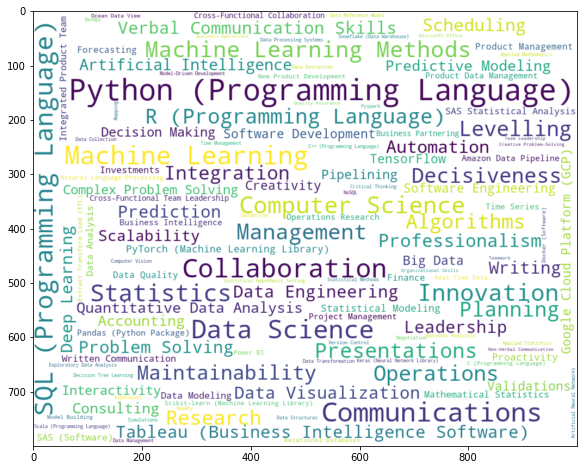

In [308]:
# wordcloud of skills and their count
wordcloud = WordCloud(width=1000, height=800, background_color='white').generate_from_frequencies(skills.set_index('skill_name')['count'].to_dict())
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")

#### Plotting only hard skills

(-0.5, 999.5, 799.5, -0.5)

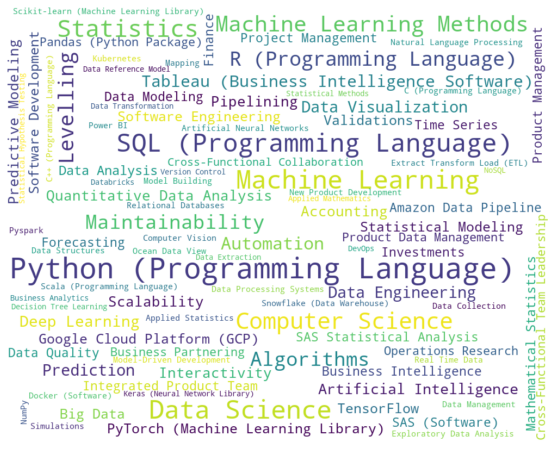

In [384]:
# hard skills wordcloud
wordcloud = WordCloud(width=1000, height=800, background_color='white').generate_from_frequencies(hardskills.set_index('skill_name')['count'].to_dict())
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
# remove grid lines from plot
plt.axis("off")

#### Plotting only soft skills

(-0.5, 999.5, 799.5, -0.5)

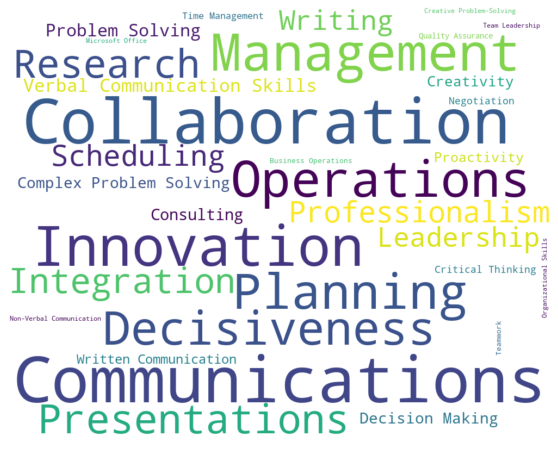

In [386]:
# soft skills wordcloud
wordcloud = WordCloud(width=1000, height=800, background_color='white').generate_from_frequencies(softskills.set_index('skill_name')['count'].to_dict())
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
# remove grid lines from plot
plt.axis("off")

#### highest and lowest salaries

Text(0, 0.5, 'Count')

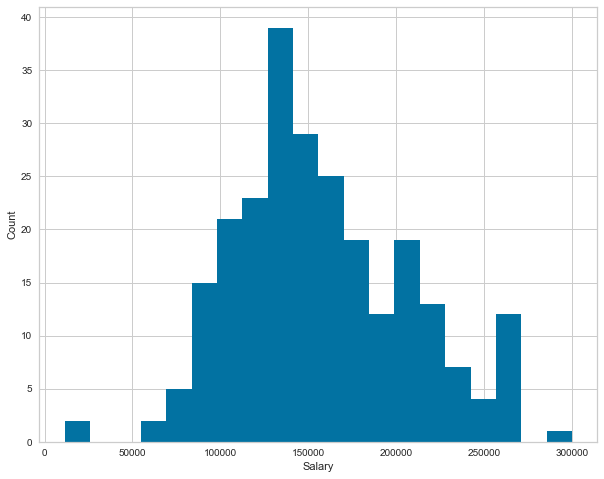

In [353]:
def get_salary(salary):
    try:
        # find second $ sign number
        salary = salary[salary.find('$', salary.find('$')+1)+1:]
        # find first space after second $ sign
        salary = salary[:salary.find(' ')]
        # remove commas
        salary = salary.replace(',','')
        # return salary
        return int(salary)
    except:
        return 0

# get salary from df
df['salary'] = df['Salary'].apply(get_salary)

# plot a histogram of salary excluding 0 with x and y labels
df[df['salary'] > 1000]['salary'].hist(bins=20, figsize=(10,8), label='Salary')
plt.xlabel('Salary')
plt.ylabel('Count')

In [361]:
# highest and lowest salary in single same bar plotly
fig = go.Figure(data=[
    go.Bar(name='Highest Salary', x=['Highest Salary'], y=[df['salary'].max()]),
    go.Bar(name='Lowest Salary', x=['Lowest Salary'], y=[df['salary'].mean()])
])
# title
fig.update_layout(title_text='Highest and Lowest Salary per year')
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()


# Dendrogram

## Plotting Dendrograms for different distance metrics

### Lets see which distance metric gives best results

#### Plotting dendrogram with Euclidean distance

In [363]:
# euclidean distance matrix for skills data
skills_data = skills.iloc[:, 3:]
skill_names = skills['skill_name'].values

# calculate euclidean distance
euclidean_distance = euclidean_distances(skills_data, skills_data)
print('euclidean_distance.shape: ', euclidean_distance.shape)

# plot dendrogram
fig = ff.create_dendrogram(euclidean_distance, orientation='left', labels=skill_names)
fig.update_layout(width=1000, height=2000)
fig.show()

euclidean_distance.shape:  (127, 127)


In [364]:
# for soft skills
softskills_data = softskills.iloc[:, 3:]
softskills_names = softskills['skill_name'].values

# calculate euclidean distance
euclidean_distance = euclidean_distances(softskills_data, softskills_data)
print('euclidean_distance.shape: ', euclidean_distance.shape)

# plot dendrogram
fig = ff.create_dendrogram(euclidean_distance, orientation='left', labels=softskills_names)
fig.update_layout(width=800, height=800)
fig.show()

euclidean_distance.shape:  (33, 33)


In [365]:
# for hard skills
hardskills_data = hardskills.iloc[:, 3:]
hardskills_names = hardskills['skill_name'].values

# calculate euclidean distance
euclidean_distance = euclidean_distances(hardskills_data, hardskills_data)
print('euclidean_distance.shape: ', euclidean_distance.shape)

# plot dendrogram
fig = ff.create_dendrogram(euclidean_distance, orientation='left', labels=hardskills_names, color_threshold=50)
fig.update_layout(width=800, height=1500)
fig.show()

euclidean_distance.shape:  (94, 94)


#### Plotting dendrogram with Cosine distance

In [366]:
skills_data = skills.iloc[:, 3:]
skill_names = skills['skill_name'].values

# calculate cosine distance
cosine_distance = 1 - cosine_similarity(skills_data)
print('cosine_distance.shape: ', cosine_distance.shape)

# plot dendrogram
fig = ff.create_dendrogram(cosine_distance, orientation='left', labels=skill_names, color_threshold=1.5)
fig.update_layout(width=1000, height=2000)
fig.show()

cosine_distance.shape:  (127, 127)


In [367]:
# for soft skills
softskills_data = softskills.iloc[:, 3:]
softskills_names = softskills['skill_name'].values

# calculate cosine distance
cosine_distance = 1 - cosine_similarity(softskills_data)
print('cosine_distance.shape: ', cosine_distance.shape)

# plot dendrogram
fig = ff.create_dendrogram(cosine_distance, orientation='left', labels=softskills_names)
fig.update_layout(width=800, height=800)
fig.show()

cosine_distance.shape:  (33, 33)


In [368]:
# for hard skills
hardskills_data = hardskills.iloc[:, 3:]
hardskills_names = hardskills['skill_name'].values

# calculate cosine distance
cosine_distance = 1 - cosine_similarity(hardskills_data)
print('cosine_distance.shape: ', cosine_distance.shape)

# plot dendrogram
fig = ff.create_dendrogram(cosine_distance, orientation='left', labels=hardskills_names)
fig.update_layout(width=800, height=1500)

cosine_distance.shape:  (94, 94)


#### Plotting dendrogram with Jaccard distance

In [387]:
skills_data = skills.iloc[:, 3:]
skill_names = skills['skill_name'].values

# jaccard distance matrix
jaccard_distance = np.zeros((len(skills_data), len(skills_data)))
for i in range(len(skills_data)):
    for j in range(len(skills_data)):
        jaccard_distance[i, j] = jaccard_score(skills_data.iloc[i], skills_data.iloc[j])
jaccard_distance.shape

# plot dendogram
import plotly.figure_factory as ff
fig = ff.create_dendrogram(jaccard_distance, orientation='left', labels=skill_names, color_threshold=1.25)
fig.update_layout(width=1000, height=2000)
fig.show()

In [370]:
# for soft skills
softskills_data = softskills.iloc[:, 3:]
softskills_names = softskills['skill_name'].values

# jaccard distance matrix
jaccard_distance = np.zeros((len(softskills_data), len(softskills_data)))
for i in range(len(softskills_data)):
    for j in range(len(softskills_data)):
        jaccard_distance[i, j] = jaccard_score(softskills_data.iloc[i], softskills_data.iloc[j])
print('jaccard_distance.shape: ', jaccard_distance.shape)

# plot dendogram
import plotly.figure_factory as ff
fig = ff.create_dendrogram(jaccard_distance, orientation='left', labels=softskills_names)
fig.update_layout(width=800, height=800)
fig.show()

jaccard_distance.shape:  (33, 33)


In [371]:
# for hard skills
hardskills_data = hardskills.iloc[:, 3:]
hardskills_names = hardskills['skill_name'].values

# jaccard distance matrix
jaccard_distance = np.zeros((len(hardskills_data), len(hardskills_data)))
for i in range(len(hardskills_data)):
    for j in range(len(hardskills_data)):
        jaccard_distance[i, j] = jaccard_score(hardskills_data.iloc[i], hardskills_data.iloc[j])
print('jaccard_distance.shape: ', jaccard_distance.shape)

# plot dendogram
import plotly.figure_factory as ff
fig = ff.create_dendrogram(jaccard_distance, orientation='left', labels=hardskills_names)
fig.update_layout(width=800, height=1800)
fig.show()

jaccard_distance.shape:  (94, 94)


### plot the dendrogram with Hamming distance

In [372]:
# hamming distance matrix for skills data
skills_data = skills.iloc[:, 3:]
skill_names = skills['skill_name'].values
hamming_distance = np.zeros((len(skills_data), len(skills_data)))
for i in range(len(skills_data)):
    for j in range(len(skills_data)):
        hamming_distance[i, j] = hamming_loss(skills_data.iloc[i], skills_data.iloc[j])
print('Hamming distance matrix shape: ', hamming_distance.shape)

# plot dendogram using plotly
import plotly.figure_factory as ff
fig = ff.create_dendrogram(hamming_distance, orientation='left', labels=skill_names, color_threshold=0.7)
fig.update_layout(width=1000, height=2000)
fig.show()

Hamming distance matrix shape:  (127, 127)


In [373]:
# hamming for softskills
softskills_data = softskills.iloc[:, 3:]
softskills_names = softskills['skill_name'].values

# hamming distance matrix
hamming_distance = np.zeros((len(softskills_names), len(softskills_names)))
for i in range(len(softskills_names)):
    for j in range(len(softskills_names)):
        hamming_distance[i, j] = hamming_loss(softskills_data.iloc[i], softskills_data.iloc[j])
hamming_distance.shape

# plot dendogram using plotly crop at 0.75
fig = ff.create_dendrogram(hamming_distance, orientation='left', labels=softskills_names)
fig.update_layout(width=800, height=1000)
fig.show()

In [374]:
# hamming for hardskills
hardskills_data = hardskills.iloc[:, 3:]
hardskills_names = hardskills['skill_name'].values

# hamming distance matrix
hamming_distance = np.zeros((len(hardskills_names), len(hardskills_names)))
for i in range(len(hardskills_names)):
    for j in range(len(hardskills_names)):
        hamming_distance[i, j] = hamming_loss(hardskills_data.iloc[i], hardskills_data.iloc[j])
hamming_distance.shape

# plot dendogram using plotly crop at 0.75
fig = ff.create_dendrogram(hamming_distance, orientation='left', labels=hardskills_names)
fig.update_layout(width=800, height=1800)
fig.show()

# K-Means Clustering

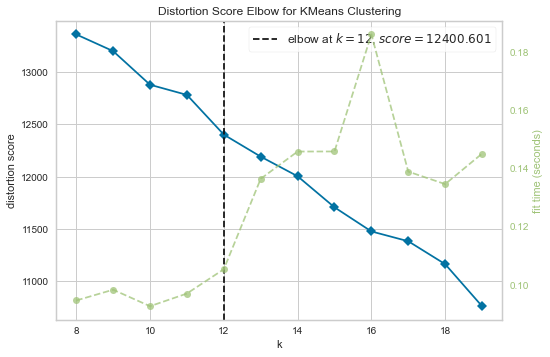

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [403]:
skills_data = skills.iloc[:, 3:]

# elbow plot
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(8, 20))
visualizer.fit(skills_data)
visualizer.show()

In [404]:
skills_data = skills.iloc[:, 3:]
skill_names = skills['skill_name'].values
kmeans = KMeans(n_clusters=12, random_state=0).fit(skills_data)

In [405]:
# import pca
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(skills_data)

# plot the 2d pca result using plotly
import plotly.express as px
fig = px.scatter(x=pca_result[:, 0], y=pca_result[:, 1], color=kmeans.labels_)
fig.update_layout(width=800, height=500)
fig.show()

In [406]:
# save clusters to a json with cluster number as key and list of skills as value

import json
clusters = {}
for i in range(len(kmeans.labels_)):
    if kmeans.labels_[i] in clusters:
        clusters[kmeans.labels_[i]].append(skill_names[i])
    else:
        clusters[kmeans.labels_[i]] = [skill_names[i]]

# convert all keys to string
clusters = {str(k): v for k, v in clusters.items()}

with open('clusters.json', 'w') as f:
    json.dump(clusters, f, indent=4)

In [409]:
# tree plot using plotly
import plotly.graph_objects as go
fig = go.Figure(go.Treemap(
    labels=skill_names,
    parents=[''] * len(skill_names),
    values=kmeans.labels_,
    branchvalues='total',
    textinfo='label+value'
))
fig.update_layout(width=800, height=800)
# show legend
fig.layout.showlegend = True
fig.show()


In [380]:
# print skill names in every cluster
for i in range(15):
    print('Cluster: ', i)
    print(skill_names[kmeans.labels_ == i])
    print('---------------------------------------------------- ')


Cluster:  0
['Interactivity' 'Cross-Functional Collaboration' 'Presentations']
---------------------------------------------------- 
Cluster:  1
['TensorFlow' 'PyTorch (Machine Learning Library)'
 'Pandas (Python Package)' 'Scikit-learn (Machine Learning Library)'
 'NumPy']
---------------------------------------------------- 
Cluster:  2
['Computer Science' 'Algorithms' 'Maintainability' 'Automation'
 'Tableau (Business Intelligence Software)' 'Data Visualization'
 'Artificial Intelligence' 'Decisiveness' 'Research' 'Integration'
 'Professionalism' 'Scheduling' 'Writing' 'Problem Solving']
---------------------------------------------------- 
Cluster:  3
['Statistics']
---------------------------------------------------- 
Cluster:  4
['Prediction' 'Data Engineering' 'Deep Learning' 'Scalability'
 'Quantitative Data Analysis' 'Predictive Modeling' 'Pipelining'
 'Software Engineering' 'Validations' 'Big Data'
 'Google Cloud Platform (GCP)' 'Software Development'
 'Statistical Modeling' 

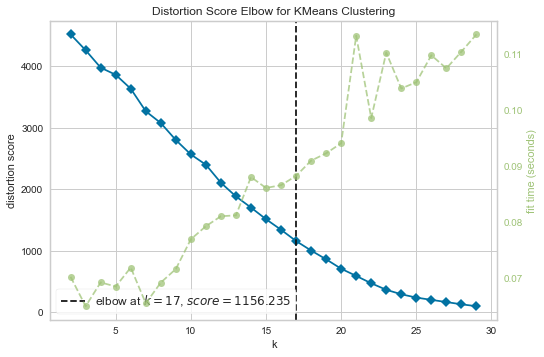

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [395]:
# softskills
softskills_data = softskills.iloc[:, 3:]

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 30))
visualizer.fit(softskills_data)
visualizer.show()

In [396]:
# print softskills names in every cluster
kmeans = KMeans(n_clusters=18, random_state=0).fit(softskills_data)
for i in range(10):
    print('Cluster: ', i)
    print(softskills_names[kmeans.labels_ == i])
    print('---------------------------------------------------- ')

Cluster:  0
['Problem Solving' 'Decision Making' 'Creativity' 'Proactivity'
 'Written Communication' 'Negotiation' 'Critical Thinking'
 'Time Management' 'Quality Assurance' 'Business Operations' 'Teamwork'
 'Organizational Skills' 'Microsoft Office' 'Non-Verbal Communication'
 'Team Leadership' 'Creative Problem-Solving']
---------------------------------------------------- 
Cluster:  1
['Communications']
---------------------------------------------------- 
Cluster:  2
['Collaboration']
---------------------------------------------------- 
Cluster:  3
['Integration']
---------------------------------------------------- 
Cluster:  4
['Planning']
---------------------------------------------------- 
Cluster:  5
['Innovation']
---------------------------------------------------- 
Cluster:  6
['Management']
---------------------------------------------------- 
Cluster:  7
['Decisiveness']
---------------------------------------------------- 
Cluster:  8
['Presentations']
----------------

In [397]:
# save clusters to a json with cluster number as key and list of skills as value

import json
clusters = {}
for i in range(len(kmeans.labels_)):
    if kmeans.labels_[i] in clusters:
        clusters[kmeans.labels_[i]].append(skill_names[i])
    else:
        clusters[kmeans.labels_[i]] = [skill_names[i]]

# convert all keys to string
clusters = {str(k): v for k, v in clusters.items()}

with open('soft_skills_clusters.json', 'w') as f:
    json.dump(clusters, f, indent=4)

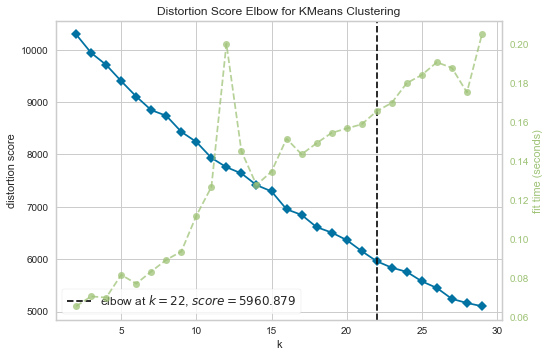

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [398]:
# for hard skills
hardskills_data = hardskills.iloc[:, 3:]

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 30))
visualizer.fit(hardskills_data)
visualizer.show()

In [399]:
# print hard skills names in every cluster
kmeans = KMeans(n_clusters=20, random_state=0).fit(hardskills_data)
for i in range(20):
    print('Cluster: ', i)
    print(hardskills_names[kmeans.labels_ == i])
    print('---------------------------------------------------- ')

Cluster:  0
['Investments']
---------------------------------------------------- 
Cluster:  1
['Tableau (Business Intelligence Software)' 'Data Visualization'
 'Quantitative Data Analysis' 'Accounting' 'Predictive Modeling'
 'Validations' 'Google Cloud Platform (GCP)' 'SAS Statistical Analysis'
 'SAS (Software)' 'Finance' 'Data Quality' 'Business Intelligence'
 'Project Management' 'Power BI' 'Relational Databases'
 'Exploratory Data Analysis' 'Data Structures' 'Business Analytics']
---------------------------------------------------- 
Cluster:  2
['R (Programming Language)']
---------------------------------------------------- 
Cluster:  3
['TensorFlow' 'PyTorch (Machine Learning Library)'
 'Pandas (Python Package)' 'Scikit-learn (Machine Learning Library)'
 'NumPy']
---------------------------------------------------- 
Cluster:  4
['Machine Learning']
---------------------------------------------------- 
Cluster:  5
['Big Data']
---------------------------------------------------- 
C

In [400]:
# save clusters to a json with cluster number as key and list of skills as value

import json
clusters = {}
for i in range(len(kmeans.labels_)):
    if kmeans.labels_[i] in clusters:
        clusters[kmeans.labels_[i]].append(skill_names[i])
    else:
        clusters[kmeans.labels_[i]] = [skill_names[i]]

# convert all keys to string
clusters = {str(k): v for k, v in clusters.items()}

with open('hard_skills_clusters.json', 'w') as f:
    json.dump(clusters, f, indent=4)